# Кластеризация текстов

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Выбираем 4 категории новостей для легковесности примера
categories = [
    'rec.sport.hockey', # хоккей
    'talk.politics.mideast', # политические новости о Ближнем Востоке
    'comp.graphics', # компьютерная графика
    'sci.crypt' # криптография
]

# Скачиваем набор данных
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

print("%d документов" % len(dataset.data))
print("%d категории" % len(dataset.target_names))

# Записываем значения категорий для каждой новости
labels = dataset.target

3903 документов
4 категории


## Предобработка данных

In [3]:
# Исходный набор данных, первые 10 примеров
for i in range(10):
    print(dataset.data[i], end='\n' + '*' * 50 + '\n\n')

From: c5ff@jupiter.sun.csd.unb.ca (COOK  Charlie)
Subject: NHL Summary parse results for games played Mon, April 19, 1993
Organization: University of New Brunswick
Lines: 79

Toronto                          1 1 1--3
Detroit                          1 4 1--6
First period
     1, Detroit, Yzerman 1 (Gallant, Ciccarelli) 4:48.
     2, Toronto, Cullen 1 (Clark, Gill) 10:44.
Second period
     3, Detroit, Sheppard 1 (Probert, Coffey) pp, 5:04.
     4, Detroit, Burr 1 (Racine) sh, 6:42.
     5, Detroit, Chiasson 1 (Coffey) pp,11:00.
     6, Detroit, Howe 1 (Yzerman, Drake) 14:46.
     7, Toronto, Gilmour 1 (Borschevsky, Ellett) pp, 19:59.
Third period
     8, Detroit, Racine 1 (Primeau, Drake) 5:10.
     9, Toronto, Lefebvre 1 (Cullen, Pearson) 7:45.

Detroit: 6    Power play: 6-2   Special goals:  pp: 2  sh: 1  Total: 3
Scorer            G    A   Pts
---------------  ---  ---  ---
Burr               1    0    1
Chiasson           1    0    1
Ciccarelli         0    1    1
Coffey           

**CountVectorizer** - это класс из библиотеки sklearn.feature_extraction.text, который используется для преобразования текстовых данных в матрицу счётчиков токенов.

In [4]:
# Создаём объект, который будет токенизировать данные
analyzer = CountVectorizer(stop_words='english').build_analyzer()

# Токенизируем наш набор данных
docs = []
for document in dataset.data:
    docs.append(analyzer(document.replace('_', '')))

# И посмотрим 10 первых примеров
for i in range(10):
    print(docs[i], end='\n\n')

['c5ff', 'jupiter', 'sun', 'csd', 'unb', 'ca', 'cook', 'charlie', 'subject', 'nhl', 'summary', 'parse', 'results', 'games', 'played', 'mon', 'april', '19', '1993', 'organization', 'university', 'new', 'brunswick', 'lines', '79', 'toronto', 'detroit', 'period', 'detroit', 'yzerman', 'gallant', 'ciccarelli', '48', 'toronto', 'cullen', 'clark', 'gill', '10', '44', 'second', 'period', 'detroit', 'sheppard', 'probert', 'coffey', 'pp', '04', 'detroit', 'burr', 'racine', 'sh', '42', 'detroit', 'chiasson', 'coffey', 'pp', '11', '00', 'detroit', 'howe', 'yzerman', 'drake', '14', '46', 'toronto', 'gilmour', 'borschevsky', 'ellett', 'pp', '19', '59', 'period', 'detroit', 'racine', 'primeau', 'drake', '10', 'toronto', 'lefebvre', 'cullen', 'pearson', '45', 'detroit', 'power', 'play', 'special', 'goals', 'pp', 'sh', 'total', 'scorer', 'pts', 'burr', 'chiasson', 'ciccarelli', 'coffey', 'drake', 'gallant', 'howe', 'primeau', 'probert', 'racine', 'sheppard', 'yzerman', 'toronto', 'power', 'play', 'sco

In [5]:
# Проверим, что число документов осталось прежним
len(docs)

3903

## Векторизация текстов

In [6]:
# Установка пакета gensim
# !pip install -U gensim

При работе в Google Colab обязательно нужно запустить код из ячейки выше, несмотря на то, что в Google Colab gensim уже предустановлен. Так gensim обновится до последней версии.  
На данный момент в Google Colab уставнолена одна из прошлых версий модуля gensim, и поэтому на ней код ниже работать не будет.

In [7]:
from gensim.models import Word2Vec

# Обучаем модель векторайзера на нашем наборе данных
# На выходе мы получим вектор признаков для каждого слова
model = Word2Vec(docs, min_count=20, vector_size=50)

# Наивный подход к созданию единого эмбеддинга для документа – средний эмбеддинг по словам
def doc_vectorizer(doc, model):
    doc_vector = []
    num_words = 0
    for word in doc:
        try:
            if num_words == 0:
                doc_vector = model.wv[word]
            else:
                doc_vector = np.add(doc_vector, model.wv[word])
            num_words += 1
        except:
            pass
     
    return np.asarray(doc_vector) / num_words

# Составляем эмбеддинги для наших документов
X = []
for doc in docs:
    X.append(doc_vectorizer(doc, model))

In [8]:
# Как выглядят первые 10 документов после векторизации 
X[:10]

[array([-1.5706978e+00, -6.8183074e-04,  7.0465004e-01,  9.3203562e-01,
         1.4800036e-01,  5.4935984e-02,  9.9808156e-01,  6.5125209e-01,
        -1.0376160e+00, -1.3997787e-01, -7.7540636e-02, -7.1704352e-01,
        -3.8315704e-01,  3.4351102e-01,  2.2668925e-01, -1.3390066e-01,
        -2.7578238e-01, -5.7096064e-02, -1.5871081e-01, -3.5182935e-01,
        -2.3665996e-01, -2.4161287e-01,  1.0276569e+00, -7.0800322e-01,
         3.0409226e-01,  3.4921959e-01, -8.9544618e-01, -3.0540844e-02,
        -2.6133013e-01, -6.9826305e-01, -1.6987248e-01,  2.8895280e-01,
         2.6523337e-01,  5.5599862e-01, -1.2183462e+00, -9.5703259e-02,
        -2.1792787e-01, -3.5123950e-01,  6.5148032e-01, -8.7967575e-01,
         5.3492159e-01, -2.1344247e-01, -4.6852824e-01,  2.5756076e-02,
         4.8957324e-01,  4.0238023e-01, -7.1108401e-01, -9.9497205e-01,
        -2.4897903e-01, -8.3936922e-02], dtype=float32),
 array([-1.1990087 , -0.11301886,  0.23134802,  0.5599184 , -0.12629618,
      

In [9]:
# Проверим размер вектора для документа
print(np.asarray(X).shape)

(3903, 50)


***Метод t-SNE (t-distributed Stochastic Neighbor Embedding)*** - это алгоритм машинного обучения для визуализации данных путем понижения их размерности до двух или трех измерений. Он широко используется для визуализации высокоразмерных данных, таких как векторные представления слов или изображений, в низкоразмерном пространстве с сохранением относительных расстояний между точками.

Процесс работы t-SNE включает в себя следующие шаги:

1. Вычисление попарных расстояний между всеми точками в исходном пространстве данных.
2. Преобразование этих расстояний в условные вероятности, которые показывают вероятность выбрать точку j в качестве соседа точки i, исходя из их расстояний.
3. Выполнение преобразования данных, понижая их размерность с сохранением условных вероятностей соседства точек как можно ближе к оригинальным.
4. Минимизация дивергенции Кульбака-Лейблера между оригинальными и преобразованными условными вероятностями.

t-SNE обладает несколькими особенностями:

- **Нелинейное понижение размерности:** t-SNE пытается сохранить относительные расстояния между точками в исходном пространстве, поэтому он способен обнаруживать сложные нелинейные зависимости между данными.
- **Чувствительность к параметрам:** некорректно подобранные параметры (такие как perplexity) могут привести к неправильным результатам.
- **Вычислительно сложный:** t-SNE может быть вычислительно затратным для больших наборов данных, особенно с высокой размерностью.

В целом, t-SNE является мощным инструментом для визуализации данных и понимания их структуры, особенно когда данные имеют сложные зависимости и высокую размерность.

Создается объект TSNE с именем tsne. В параметре n_components указывается количество компонентов, к которым будет выполнено понижение размерности. Здесь мы устанавливаем n_components=2, чтобы получить двумерное представление данных.

In [10]:
# t-SNE – метод понижения размерности
from sklearn.manifold import TSNE

X = np.array(X)

# Создаём объект для выполнения t-SNE
tsne = TSNE(n_components=2, random_state=0)

# Преобразуем наши данные, понизив размерность с 50 до 2
X_transformed = tsne.fit_transform(X)

print(np.asarray(X_transformed).shape)

(3903, 2)


## Кластеризация

Кластеризация KMeans пытается найти группы точек в пространстве данных, которые близки друг к другу. Каждый кластер характеризуется своим центром (центроидом), и точки внутри кластера имеют меньшее расстояние до центроида этого кластера, чем до центроидов других кластеров.

In [11]:
# Создаём KMeans кластеризатор 
kmeans = KMeans(n_clusters=4)

# Обучим кластеризатор на подготовленных данных
kmeans.fit(X)

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4)

In [12]:
# Получаем предсказанные кластеры
y_pred = kmeans.labels_.astype(int)

# Координаты полученных центроидов
print ("Координаты центроидов:\n", kmeans.cluster_centers_)

Координаты центроидов:
 [[-5.87043047e-01 -2.39484549e-01  2.55156636e-01 -2.68194973e-02
   4.53445613e-02  6.78658485e-03  6.02923989e-01  4.21861291e-01
  -5.24404407e-01  6.79172158e-01  1.36221990e-01 -5.64980328e-01
  -2.52627045e-01  6.20638967e-01 -4.90290135e-01  6.71619773e-01
   2.89088726e-01  5.73524833e-01 -7.08085716e-01 -6.42604947e-01
   3.50145757e-01  8.88034284e-01  1.39931524e+00  2.16268167e-01
   1.25628203e-01  1.74077630e-01 -7.75548518e-02 -3.65148813e-01
  -1.99520797e-01 -4.99474674e-01  6.80329800e-01 -1.87770128e-01
   2.92276233e-01 -1.42591447e-01 -4.81966883e-02  9.94852707e-02
   7.61955082e-01  3.80942225e-02  9.79480371e-02 -7.20596552e-01
   4.70669061e-01 -4.28660601e-01 -2.12279499e-01 -2.04658136e-01
   7.51655936e-01  2.24160820e-01  7.03670830e-02 -2.77676970e-01
   3.53123434e-02 -1.07551500e-01]
 [-1.89790666e-01 -3.37035596e-01 -6.27388060e-02 -5.17945066e-02
  -8.80604982e-02 -2.85102963e-01  3.88210446e-01  3.92440110e-01
  -2.72009283e-01

1. **Коэффициент силуэта (Silhouette Score)**: Этот коэффициент измеряет, насколько объект хорошо согласуется со своим собственным кластером по сравнению с другими кластерами. Он находится в диапазоне от -1 до 1, где высокое значение указывает на хорошую кластеризацию, а отрицательное значение означает, что объект был неправильно присвоен кластеру.

2. **Однородность (Homogeneity Score)**: Эта метрика оценивает, насколько каждый кластер содержит только точки данных, которые являются членами одного класса. Она принимает значения от 0 до 1, где 1 означает идеальную однородность.

3. **Полнота (Completeness Score)**: Эта метрика оценивает, насколько все члены одного класса относятся к одному кластеру. Она также принимает значения от 0 до 1, где 1 указывает на идеальную полноту.

4. **V-мера (V-Measure)**: Это гармоническое среднее между однородностью и полнотой. Она также принимает значения от 0 до 1, где 1 указывает на идеальное соответствие.

Эти метрики помогают понять, насколько хорошо выполняется кластеризация и какие кластеры считаются информативными и различимыми. Все метрики близки к 1 указывают на хорошее качество кластеризации.

In [13]:
# Метрики
print ("Коэффициент силуэта: %0.3f" % metrics.silhouette_score(X, y_pred, metric='euclidean'))
print("Однородность: %0.3f" % metrics.homogeneity_score(labels, y_pred))
print("Полнота: %0.3f" % metrics.completeness_score(labels, y_pred))
print("V-мера: %0.3f" % metrics.v_measure_score(labels, y_pred))

Коэффициент силуэта: 0.242
Однородность: 0.569
Полнота: 0.576
V-мера: 0.572


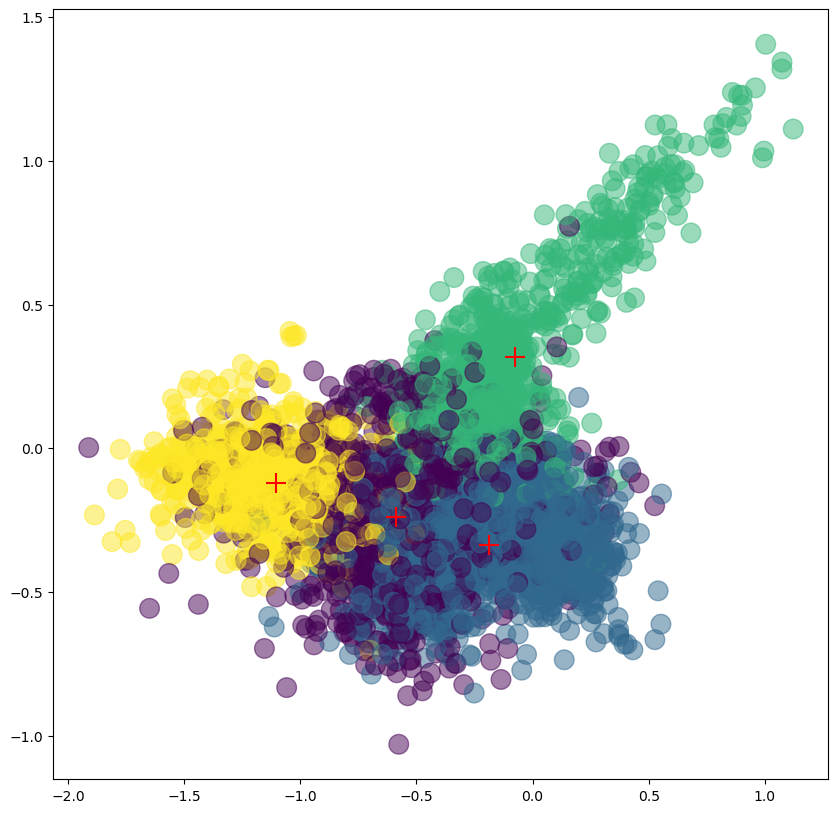

In [14]:
# Графики полученных кластеров
plt.rcParams['figure.figsize'] = 10, 10
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=200, alpha=.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='+')
plt.show()

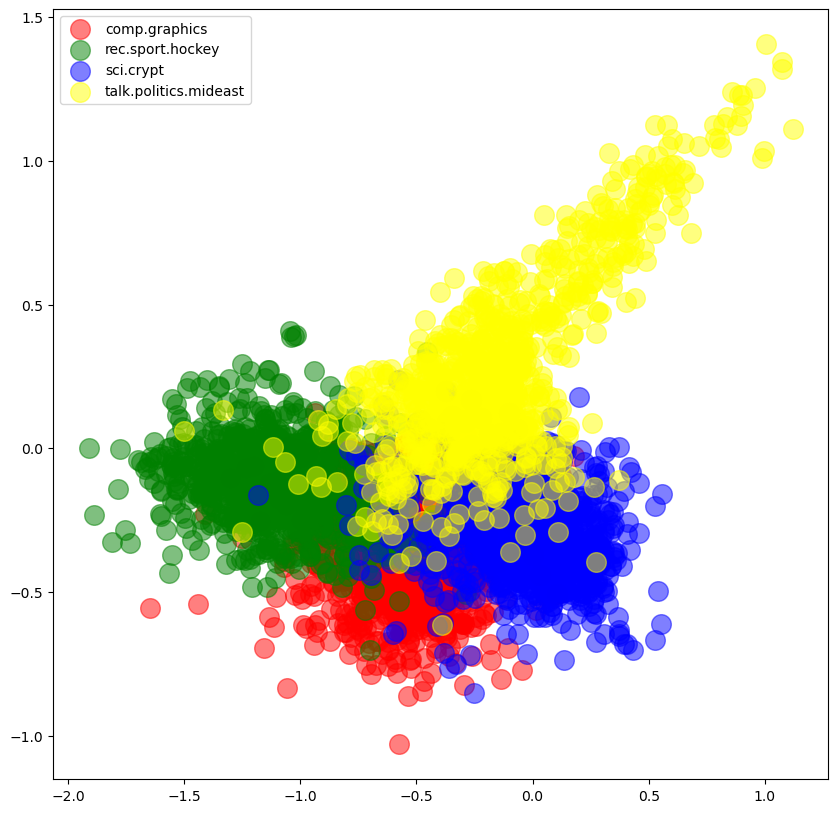

In [15]:
# Построим график истинных классов
colors = ("red", "green", "blue", "yellow")

for i in range(4):
    plt.scatter(X[labels==i][:, 0], X[labels==i][:, 1], \
                s=200, alpha=.5, c=colors[i], label=dataset.target_names[i])
    plt.legend(loc=2)

plt.show()

# Коэффициент силуэта. Практика
В задачах используется датасет из прошлого модуля:

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

n_samples = 1500
dataset = datasets.make_blobs(n_samples=n_samples, centers=2, center_box=(-7.0, 7.5),
                              cluster_std=[1.4, 1.7],
                              random_state=42)
X_2, _ = datasets.make_blobs(n_samples=n_samples, random_state=170, centers=[[-4, -3]], cluster_std=[1.9])
transformation = [[1.2, -0.8], [-0.4, 1.7]]
X_2 = np.dot(X_2, transformation)
X, y = np.concatenate((dataset[0], X_2)), np.concatenate((dataset[1], np.array([2] * len(X_2))))

Коэффициент силуэта можно посчитать при помощи реализации из библиотеки sklearn:

**Коэффициент силуэта (Silhouette Score)** - это метрика, используемая для оценки качества кластеризации данных. Она предоставляет меру того, насколько объект хорошо согласуется со своим собственным кластером по сравнению с другими кластерами.

Для каждого объекта вычисляется силуэт, который является мерой близости этого объекта к другим объектам внутри его собственного кластера по сравнению с объектами в соседних кластерах. Значение силуэта находится в диапазоне от -1 до 1:

- Значение близкое к +1 указывает на то, что объект хорошо согласуется со своим собственным кластером и плохо согласуется с соседними кластерами, что является хорошим результатом.
- Значение близкое к 0 указывает на то, что объект находится близко к границе между двумя кластерами.
- Значение близкое к -1 указывает на то, что объект находится ближе к кластеру, который не является его собственным, чем к своему собственному кластеру, что указывает на плохое качество кластеризации.

Общий коэффициент силуэта для всего набора данных вычисляется как среднее значение силуэтов для всех объектов. Коэффициент силуэта является полезной метрикой для сравнения различных методов кластеризации и выбора оптимального количества кластеров.

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# сначала получим предсказанные кластеры при помощи метода кластеризации
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
kmeans_pred = kmeans.labels_

# теперь посчитаем коэффициент силуэта
silhouette_score(X=X, labels=kmeans_pred, metric='euclidean')

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.5131209788437305

В качестве параметров в функции silhouette_score используются:

o	X — массив признаков объектов выборки или массив попарных расстояний между объектами;

o	Y — массив предсказанных кластеров для объектов выборки;

o	metric — метрика, используемая для вычисления расстояния между объектами, мы будем использовать euclidean (Евклидово расстояние), полный список названий метрик можно увидеть здесь.

Полное описание функции можно прочитать в документации (англ.).

При решении заданий модуля стандартизация должна быть выключена.


***Gaussian Mixture Model(GMM)*** - это вероятностная модель, которая используется для моделирования смеси гауссовских распределений в пространстве признаков. Она предполагает, что данные сгенерированы из смеси нескольких гауссовских распределений, каждое из которых соответствует одному из скрытых кластеров.

Основные характеристики GMM:

1. **Количество компонентов**: Это количество гауссовских распределений, которые используются для аппроксимации смеси данных. Каждый компонент соответствует одному кластеру.

2. **Параметры компонентов**: Каждый компонент определяется с помощью среднего значения (центра) и ковариационной матрицы. Среднее значение определяет центр кластера в пространстве признаков, а ковариационная матрица определяет форму и ориентацию кластера.

3. **Веса компонентов**: Каждый компонент имеет свой вес, который определяет вклад компонента в смесь. Вес компонента указывает на вероятность выбора данного компонента при генерации данных.

Процесс обучения GMM заключается в оценке параметров каждого компонента (среднего значения, ковариационной матрицы и веса) с использованием метода максимального правдоподобия или метода ожидания-максимизации (Expectation-Maximization, EM). После обучения модели можно использовать для определения принадлежности кластеру новых точек данных.

GMM часто используется для кластеризации данных, особенно в случаях, когда кластеры имеют сложную форму или перекрываются друг с другом. Он также может быть использован для оценки плотности вероятности данных.

# Задание 7.11.1
Обучите модель GaussianMixture с параметрами n_components=3 и random_state=42 на признаках исходного датасета. Посчитайте коэффициент силуэта для получившейся кластеризации. 

In [18]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Предполагается, что X и y определены, как в вашем примере

# Создайте экземпляр модели GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=42)

# Обучите модель на данных
gmm.fit(X)

# Получите предсказанные метки
gmm_pred = gmm.predict(X)

# Вычислите коэффициент силуэта
silhouette_coefficient = silhouette_score(X=X, labels=gmm_pred, metric='euclidean')
print("Коэффициент силуэта:", silhouette_coefficient)

Коэффициент силуэта: 0.49893287606943293


# Задание 7.11.2
 Сравните результаты кластеризации четырёх рассмотренных алгоритмов на исходном датасете при помощи коэффициента силуэта, инициализируйте алгоритмы со следующими параметрами:

	K-means — n_clusters=3, random_state=42

	EM-алгоритм (GaussianMixture) — n_components=3, random_state=42

	Агломеративная кластеризация – n_clusters=3

	DBSCAN – eps=0.9, min_samples=35

Укажите максимальное значение коэффициента силуэта, полученное при помощи данных моделей. 

1. **K-means**:
   - Использует центроиды для разделения данных.
   - Подходит для кластеров с простой формой.

2. **EM-алгоритм (Gaussian Mixture)**:
   - Моделирует данные как смесь гауссовских распределений.
   - Хорошо работает с перекрывающимися кластерами.

3. **Агломеративная кластеризация**:
   - Объединяет близкие точки данных, чтобы сформировать кластеры.
   - Подходит для различных форм и размеров кластеров.

4. **DBSCAN**:
   - Основан на плотности данных.
   - Хорошо обрабатывает шум и выбросы, и может обнаруживать кластеры произвольной формы.

In [19]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# K-means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_pred = kmeans.fit_predict(X)
kmeans_silhouette = silhouette_score(X, kmeans_pred)

# EM-алгоритм (GaussianMixture)
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_pred = gmm.fit_predict(X)
gmm_silhouette = silhouette_score(X, gmm_pred)

# Агломеративная кластеризация
agg_clustering = AgglomerativeClustering(n_clusters=3)
agg_pred = agg_clustering.fit_predict(X)
agg_silhouette = silhouette_score(X, agg_pred)

# DBSCAN
dbscan = DBSCAN(eps=0.9, min_samples=35)
dbscan_pred = dbscan.fit_predict(X)
dbscan_silhouette = silhouette_score(X, dbscan_pred)

# Вывод максимального значения коэффициента силуэта
max_silhouette = max(kmeans_silhouette, gmm_silhouette, agg_silhouette, dbscan_silhouette)
print("Максимальное значение коэффициента силуэта:", max_silhouette)

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Максимальное значение коэффициента силуэта: 0.5131209788437305


# Задание 7.11.3
Подберите оптимальное количество кластеров с помощью коэффициента силуэта. Для этого найдите такое число кластеров, при котором значение коэффициента будет максимальным.

В трёх из рассмотренных нами алгоритмов необходимо задать число кластеров при инициализации: K-means, EM-алгоритм и агломеративная кластеризация.

Найдите значение коэффициента силуэта для данных алгоритмов при числе кластеров от 2 до 10 включительно. Для K-means и EM-алгоритма установите значение random_state=42.

В качестве ответа через пробел введите число кластеров, при котором значение коэффициента силуэта для результатов кластеризации было наибольшим для каждого из алгоритмов. Вводите в следующем порядке: K-means, EM-алгоритм, агломеративная кластеризация.

In [20]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Диапазон числа кластеров
num_clusters_range = range(2, 11)

# Инициализация переменных для хранения лучших значений коэффициента силуэта
best_kmeans_silhouette = -1
best_kmeans_num_clusters = -1

best_gmm_silhouette = -1
best_gmm_num_clusters = -1

best_agg_silhouette = -1
best_agg_num_clusters = -1

# Перебор числа кластеров
for num_clusters in num_clusters_range:
    # K-means
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_pred = kmeans.fit_predict(X)
    kmeans_silhouette = silhouette_score(X, kmeans_pred)
    if kmeans_silhouette > best_kmeans_silhouette:
        best_kmeans_silhouette = kmeans_silhouette
        best_kmeans_num_clusters = num_clusters

    # EM-алгоритм (GaussianMixture)
    gmm = GaussianMixture(n_components=num_clusters, random_state=42)
    gmm_pred = gmm.fit_predict(X)
    gmm_silhouette = silhouette_score(X, gmm_pred)
    if gmm_silhouette > best_gmm_silhouette:
        best_gmm_silhouette = gmm_silhouette
        best_gmm_num_clusters = num_clusters

    # Агломеративная кластеризация
    agg_clustering = AgglomerativeClustering(n_clusters=num_clusters)
    agg_pred = agg_clustering.fit_predict(X)
    agg_silhouette = silhouette_score(X, agg_pred)
    if agg_silhouette > best_agg_silhouette:
        best_agg_silhouette = agg_silhouette
        best_agg_num_clusters = num_clusters

# Вывод оптимального числа кластеров для каждого алгоритма
print("Оптимальное число кластеров для K-means:", best_kmeans_num_clusters)
print("Оптимальное число кластеров для EM-алгоритма:", best_gmm_num_clusters)
print("Оптимальное число кластеров для агломеративной кластеризации:", best_agg_num_clusters)

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/admin/anacond

Оптимальное число кластеров для K-means: 3
Оптимальное число кластеров для EM-алгоритма: 4
Оптимальное число кластеров для агломеративной кластеризации: 4


# Однородность. Практика
Однородность можно посчитать при помощи реализации из библиотеки sklearn:

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import homogeneity_score
from sklearn.preprocessing import StandardScaler


# сначала получим предсказанные кластеры при помощи метода кластеризации
kmeans = KMeans(n_clusters=3, random_state=42)
X = StandardScaler().fit_transform(X)
kmeans.fit(X)
kmeans_pred = kmeans.labels_ # теперь посчитаем однородностьhomogeneity_score(labels_true=y, labels_pred=kmeans_pred)

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Задание 7.12.1
Сравните результаты кластеризации алгоритмов k-means, GaussianMixture, AgglomerativeClustering и DBSCAN на исходном датасете при помощи однородности, инициализируйте алгоритмы со следующими параметрами:

	k-means — n_clusters=3, random_state=42

	GaussianMixture — n_components=3, random_state=42

	AgglomerativeClustering — n_clusters=3

	DBSCAN — eps=0.9, min_samples=35

В качестве ответа укажите максимальное значение однородности, полученное при помощи данных моделей. 
При решении задания модуля стандартизация должна быть включена.

In [22]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import homogeneity_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

# Generate dataset
n_samples = 1500
dataset = datasets.make_blobs(n_samples=n_samples, centers=2, center_box=(-7.0, 7.5),
                              cluster_std=[1.4, 1.7],
                              random_state=42)
X_2, _ = datasets.make_blobs(n_samples=n_samples, random_state=170, centers=[[-4, -3]], cluster_std=[1.9])
transformation = [[1.2, -0.8], [-0.4, 1.7]]
X_2 = np.dot(X_2, transformation)
X, y = np.concatenate((dataset[0], X_2)), np.concatenate((dataset[1], np.array([2] * len(X_2))))

# K-means
kmeans = KMeans(n_clusters=3, random_state=42)
X_scaled = StandardScaler().fit_transform(X)
kmeans.fit(X_scaled)
kmeans_pred = kmeans.labels_
kmeans_homogeneity = homogeneity_score(labels_true=y, labels_pred=kmeans_pred)

# GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_scaled)
gmm_pred = gmm.predict(X_scaled)
gmm_homogeneity = homogeneity_score(labels_true=y, labels_pred=gmm_pred)

# AgglomerativeClustering
agg_clustering = AgglomerativeClustering(n_clusters=3)
agg_pred = agg_clustering.fit_predict(X_scaled)
agg_homogeneity = homogeneity_score(labels_true=y, labels_pred=agg_pred)

# DBSCAN
dbscan = DBSCAN(eps=0.9, min_samples=35)
dbscan_pred = dbscan.fit_predict(X_scaled)
dbscan_homogeneity = homogeneity_score(labels_true=y, labels_pred=dbscan_pred)

# Max homogeneity score
max_homogeneity = max(kmeans_homogeneity, gmm_homogeneity, agg_homogeneity, dbscan_homogeneity)
print("Максимальное значение однородности:", max_homogeneity)

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Максимальное значение однородности: 0.9339791347507893


# Полнота. Практика
Полноту можно посчитать при помощи реализации из библиотеки sklearn:

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import completeness_score

# сначала получим предсказанные кластеры при помощи метода кластеризации
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
kmeans_pred = kmeans.labels_

# теперь посчитаем полноту
completeness_score(labels_true=y, labels_pred=kmeans_pred)

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.7842373379017128

# Задание 7.13.1
Обучите модель GaussianMixture с параметрами n_components=3 и random_state=42 на признаках исходного датасета. Посчитайте полноту для получившейся кластеризации.
Подсказка: При решении задания модуля стандартизация должна быть включена. 

In [24]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import completeness_score
from sklearn.preprocessing import StandardScaler

# Инициализация модели GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=42)

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Обучение модели на данных
gmm.fit(X_scaled)

# Получение предсказанных меток
gmm_pred = gmm.predict(X_scaled)

# Вычисление полноты
completeness = completeness_score(labels_true=y, labels_pred=gmm_pred)
print("Полнота для кластеризации GaussianMixture:", completeness)

Полнота для кластеризации GaussianMixture: 0.9325740421656737


# Задание 7.13.2
Сравните результаты кластеризации алгоритмов k-means, GaussianMixture, AgglomerativeClustering и DBSCAN на исходном датасете при помощи полноты, инициализируйте алгоритмы со следующими параметрами:

	k-means — n_clusters=3, random_state=42

	GaussianMixture — n_components=3, random_state=42

	AgglomerativeClustering — n_clusters=3

	DBSCAN — eps=0.9, min_samples=35

В качестве ответа укажите максимальное значение полноты, полученное при помощи данных моделей.
Подсказка: При решении задания модуля стандартизация должна быть включена. 

In [25]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import completeness_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

# Генерация датасета
n_samples = 1500
dataset = datasets.make_blobs(n_samples=n_samples, centers=2, center_box=(-7.0, 7.5),
                              cluster_std=[1.4, 1.7],
                              random_state=42)
X_2, _ = datasets.make_blobs(n_samples=n_samples, random_state=170, centers=[[-4, -3]], cluster_std=[1.9])
transformation = [[1.2, -0.8], [-0.4, 1.7]]
X_2 = np.dot(X_2, transformation)
X, y = np.concatenate((dataset[0], X_2)), np.concatenate((dataset[1], np.array([2] * len(X_2))))

# Инициализация StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
kmeans_pred = kmeans.labels_
kmeans_completeness = completeness_score(labels_true=y, labels_pred=kmeans_pred)

# GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_scaled)
gmm_pred = gmm.predict(X_scaled)
gmm_completeness = completeness_score(labels_true=y, labels_pred=gmm_pred)

# AgglomerativeClustering
agg_clustering = AgglomerativeClustering(n_clusters=3)
agg_pred = agg_clustering.fit_predict(X_scaled)
agg_completeness = completeness_score(labels_true=y, labels_pred=agg_pred)

# DBSCAN
dbscan = DBSCAN(eps=0.9, min_samples=35)
dbscan_pred = dbscan.fit_predict(X_scaled)
dbscan_completeness = completeness_score(labels_true=y, labels_pred=dbscan_pred)

# Максимальное значение полноты
max_completeness = max(kmeans_completeness, gmm_completeness, agg_completeness, dbscan_completeness)
print("Максимальное значение полноты:", max_completeness)

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Максимальное значение полноты: 0.9325740421656737


# V-мера. Практика
V-меру можно посчитать при помощи реализации из библиотеки sklearn:

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import v_measure_score

# сначала получим предсказанные кластеры при помощи метода кластеризации
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
kmeans_pred = kmeans.labels_

# теперь посчитаем полноту
v_measure_score(labels_true=y, labels_pred=kmeans_pred)

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.795592702456356

# Задание 7.14.1
Обучите модель GaussianMixture с параметрами n_components=3 и random_state=42 на признаках исходного датасета. Посчитайте v-меру для получившейся кластеризации.
Подсказка: При решении задания модуля стандартизация должна быть включена. 

In [27]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import v_measure_score
from sklearn.preprocessing import StandardScaler

# Инициализация модели GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=42)

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Обучение модели на данных
gmm.fit(X_scaled)

# Получение предсказанных меток
gmm_pred = gmm.predict(X_scaled)

# Вычисление v-меры
v_measure = v_measure_score(labels_true=y, labels_pred=gmm_pred)
print("V-мера для кластеризации GaussianMixture:", v_measure)

V-мера для кластеризации GaussianMixture: 0.9332760595996924


# Задание 7.14.2
Сравните результаты кластеризации алгоритмов k-means, GaussianMixture, AgglomerativeClustering и DBSCAN на исходном датасете при помощи v-меры, инициализируйте алгоритмы со следующими параметрами:

	k-means — n_clusters=3, random_state=42

	GaussianMixture — n_components=3, random_state=42

	AgglomerativeClustering — n_clusters=3

	DBSCAN — eps=0.9, min_samples=35

В качестве ответа укажите максимальное значение v-меры, полученное при помощи данных моделей. 

In [28]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import v_measure_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

# Генерация датасета
n_samples = 1500
dataset = datasets.make_blobs(n_samples=n_samples, centers=2, center_box=(-7.0, 7.5),
                              cluster_std=[1.4, 1.7],
                              random_state=42)
X_2, _ = datasets.make_blobs(n_samples=n_samples, random_state=170, centers=[[-4, -3]], cluster_std=[1.9])
transformation = [[1.2, -0.8], [-0.4, 1.7]]
X_2 = np.dot(X_2, transformation)
X, y = np.concatenate((dataset[0], X_2)), np.concatenate((dataset[1], np.array([2] * len(X_2))))

# Инициализация StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
kmeans_pred = kmeans.labels_
kmeans_v_measure = v_measure_score(labels_true=y, labels_pred=kmeans_pred)

# GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_scaled)
gmm_pred = gmm.predict(X_scaled)
gmm_v_measure = v_measure_score(labels_true=y, labels_pred=gmm_pred)

# AgglomerativeClustering
agg_clustering = AgglomerativeClustering(n_clusters=3)
agg_pred = agg_clustering.fit_predict(X_scaled)
agg_v_measure = v_measure_score(labels_true=y, labels_pred=agg_pred)

# DBSCAN
dbscan = DBSCAN(eps=0.9, min_samples=35)
dbscan_pred = dbscan.fit_predict(X_scaled)
dbscan_v_measure = v_measure_score(labels_true=y, labels_pred=dbscan_pred)

# Максимальное значение v-меры
max_v_measure = max(kmeans_v_measure, gmm_v_measure, agg_v_measure, dbscan_v_measure)
print("Максимальное значение v-меры:", max_v_measure)

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Максимальное значение v-меры: 0.9332760595996924


# Задание 7.14.3
Сравним модификации K-means с использованием случайной инициализации центроид и с использованием алгоритма K-means++ для инициализации центроид.

Для этого обучим на исходном датасете 2 модели k-means со следующими параметрами:

	n_clusters=3, init='k-means++', n_init=1, random_state=42

	n_clusters=3, init='random', n_init=1, random_state=42

В качестве ответа укажите максимальное значение v-меры, полученное при помощи данных моделей.

Подсказка: При решении задания модуля стандартизация должна быть включена. 

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import v_measure_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

# Генерация датасета
n_samples = 1500
dataset = datasets.make_blobs(n_samples=n_samples, centers=2, center_box=(-7.0, 7.5),
                              cluster_std=[1.4, 1.7],
                              random_state=42)
X_2, _ = datasets.make_blobs(n_samples=n_samples, random_state=170, centers=[[-4, -3]], cluster_std=[1.9])
transformation = [[1.2, -0.8], [-0.4, 1.7]]
X_2 = np.dot(X_2, transformation)
X, y = np.concatenate((dataset[0], X_2)), np.concatenate((dataset[1], np.array([2] * len(X_2))))

# Инициализация StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means с использованием алгоритма K-means++
kmeans_pp = KMeans(n_clusters=3, init='k-means++', n_init=1, random_state=42)
kmeans_pp.fit(X_scaled)
kmeans_pp_pred = kmeans_pp.labels_
kmeans_pp_v_measure = v_measure_score(labels_true=y, labels_pred=kmeans_pp_pred)

# K-means с использованием случайной инициализации
kmeans_random = KMeans(n_clusters=3, init='random', n_init=1, random_state=42)
kmeans_random.fit(X_scaled)
kmeans_random_pred = kmeans_random.labels_
kmeans_random_v_measure = v_measure_score(labels_true=y, labels_pred=kmeans_random_pred)

# Максимальное значение v-меры
max_v_measure_km = max(kmeans_pp_v_measure, kmeans_random_v_measure)
print("Максимальное значение v-меры для K-means:", max_v_measure_km)

Максимальное значение v-меры для K-means: 0.7903450330611903


# Задание 7.14.4
Теперь сравним k-means с ещё одной модификацией — K-means mini batch. Воспользоваться реализацией K-means mini batch в библиотеке sklearn можно следующим образом:

from sklearn.cluster import MiniBatchKMeans

kmeans_mini_batch = MiniBatchKMeans(n_clusters=3, random_state= 42)

kmeans_mini_batch.fit(X)

kmeans_mini_batch_pred = kmeans_mini_batch.labels_

Механизм кластеризации версии K-means mini batch схож с оригинальной версией алгоритма. Обучите на исходном датасете две модели:

	k-means с параметрами n_clusters=3, n_init=1, random_state=42

	MiniBatchKMeans с параметрами n_clusters=3, n_init=1, random_state=42

В качестве ответа введите максимальное значение v-меры, полученное при помощи данных моделей. В задании может понадобиться, а может не понадобиться нормализация и это нужно проверить во время решения задания. 


In [30]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.cluster import v_measure_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

# Генерация датасета
n_samples = 1500
dataset = datasets.make_blobs(n_samples=n_samples, centers=2, center_box=(-7.0, 7.5),
                              cluster_std=[1.4, 1.7],
                              random_state=42)
X_2, _ = datasets.make_blobs(n_samples=n_samples, random_state=170, centers=[[-4, -3]], cluster_std=[1.9])
transformation = [[1.2, -0.8], [-0.4, 1.7]]
X_2 = np.dot(X_2, transformation)
X, y = np.concatenate((dataset[0], X_2)), np.concatenate((dataset[1], np.array([2] * len(X_2))))

# Инициализация StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means
kmeans = KMeans(n_clusters=3, n_init=1, random_state=42)
kmeans.fit(X_scaled)
kmeans_pred = kmeans.labels_
kmeans_v_measure = v_measure_score(labels_true=y, labels_pred=kmeans_pred)

# K-means mini batch
kmeans_mini_batch = MiniBatchKMeans(n_clusters=3, n_init=1, random_state=42)
kmeans_mini_batch.fit(X_scaled)
kmeans_mini_batch_pred = kmeans_mini_batch.labels_
kmeans_mini_batch_v_measure = v_measure_score(labels_true=y, labels_pred=kmeans_mini_batch_pred)

# Максимальное значение v-меры
max_v_measure = max(kmeans_v_measure, kmeans_mini_batch_v_measure)
print("Максимальное значение v-меры:", max_v_measure)

Максимальное значение v-меры: 0.804697430165486


# Задание 7.14.5
Рассмотрим агломеративную кластеризацию. Сравним, как влияет на качество кластеризации разный тип расстояния между кластерами.
Обучите на исходном датасете четыре модели AgglomerativeClustering с параметром n_clusters=3, меняя параметр linkage.
В качестве ответа укажите максимальное значение v-меры, полученное при помощи данных моделей. В задании может понадобиться, а может не понадобиться нормализация и это нужно проверить во время решения 

In [31]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import v_measure_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

# Генерация датасета
n_samples = 1500
dataset = datasets.make_blobs(n_samples=n_samples, centers=2, center_box=(-7.0, 7.5),
                              cluster_std=[1.4, 1.7],
                              random_state=42)
X_2, _ = datasets.make_blobs(n_samples=n_samples, random_state=170, centers=[[-4, -3]], cluster_std=[1.9])
transformation = [[1.2, -0.8], [-0.4, 1.7]]
X_2 = np.dot(X_2, transformation)
X, y = np.concatenate((dataset[0], X_2)), np.concatenate((dataset[1], np.array([2] * len(X_2))))

# Инициализация StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Массив для хранения v-мер
v_measure_scores = []

# AgglomerativeClustering с разными типами linkage
linkage_types = ['ward', 'complete', 'average', 'single']
for linkage in linkage_types:
    # Обучение модели
    agg_clustering = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    agg_pred = agg_clustering.fit_predict(X_scaled)
    # Вычисление v-меры
    v_measure = v_measure_score(labels_true=y, labels_pred=agg_pred)
    v_measure_scores.append(v_measure)

# Максимальное значение v-меры
max_v_measure = max(v_measure_scores)
print("Максимальное значение v-меры:", max_v_measure)

Максимальное значение v-меры: 0.9079037199053294


# Задание 7.14.6
Сравним, как влияет предварительный расчёт матрицы смежности на качество агломеративной кластеризации.

Обучите на исходном датасете две модели AgglomerativeClustering:

	с параметром n_clusters=3

	с параметром n_clusters=3 и предварительно посчитанной матрицей смежности для объектов датасета

Построить матрицу смежности можно с помощью кода:

fromsklearn.neighborsimport kneighbors_graph

connectivity = kneighbors_graph(X, n_neighbors=6, include_self=False)

connectivity = 0.5 * (connectivity + connectivity.T)

В качестве ответа введите максимальное значение v-меры, полученное при помощи данных моделей. В задании может понадобиться, а может не понадобиться нормализация и это нужно проверить во время решения задания. 

In [32]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import v_measure_score
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

# Генерация датасета
n_samples = 1500
dataset = datasets.make_blobs(n_samples=n_samples, centers=2, center_box=(-7.0, 7.5),
                              cluster_std=[1.4, 1.7],
                              random_state=42)
X_2, _ = datasets.make_blobs(n_samples=n_samples, random_state=170, centers=[[-4, -3]], cluster_std=[1.9])
transformation = [[1.2, -0.8], [-0.4, 1.7]]
X_2 = np.dot(X_2, transformation)
X, y = np.concatenate((dataset[0], X_2)), np.concatenate((dataset[1], np.array([2] * len(X_2))))

# Инициализация StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# AgglomerativeClustering без предварительного расчета матрицы смежности
agg_clustering_no_connectivity = AgglomerativeClustering(n_clusters=3)
agg_pred_no_connectivity = agg_clustering_no_connectivity.fit_predict(X_scaled)
v_measure_no_connectivity = v_measure_score(labels_true=y, labels_pred=agg_pred_no_connectivity)

# Предварительный расчет матрицы смежности
connectivity = kneighbors_graph(X_scaled, n_neighbors=6, include_self=False)
connectivity = 0.5 * (connectivity + connectivity.T)

# AgglomerativeClustering с предварительным расчетом матрицы смежности
agg_clustering_with_connectivity = AgglomerativeClustering(n_clusters=3, connectivity=connectivity)
agg_pred_with_connectivity = agg_clustering_with_connectivity.fit_predict(X_scaled)
v_measure_with_connectivity = v_measure_score(labels_true=y, labels_pred=agg_pred_with_connectivity)

# Максимальное значение v-меры
max_v_measure = max(v_measure_no_connectivity, v_measure_with_connectivity)
print("Максимальное значение v-меры:", max_v_measure)

Максимальное значение v-меры: 0.9079037199053294


# Задание 7.14.7
Алгоритм DBSCAN очень требователен к параметрам: небольшое изменение в параметре eps или min_samples может изменить результат и качество кластеризации.

Обучите на исходном датасете две модели DBSCAN:

	с параметрами eps=0.9, min_samples=35

	с параметрами eps=0.8, min_samples=35

В качестве ответа укажите максимальное значение v-меры, полученное при помощи данных моделей. В задании может понадобиться, а может не понадобиться нормализация и это нужно проверить во время решения задания. 

In [33]:
# DBSCAN с разными параметрами
dbscan_eps_09 = DBSCAN(eps=0.9, min_samples=35)
dbscan_eps_08 = DBSCAN(eps=0.8, min_samples=35)

dbscan_eps_09_pred = dbscan_eps_09.fit_predict(X)
dbscan_eps_08_pred = dbscan_eps_08.fit_predict(X)

v_measure_eps_09 = v_measure_score(labels_true=y, labels_pred=dbscan_eps_09_pred)
v_measure_eps_08 = v_measure_score(labels_true=y, labels_pred=dbscan_eps_08_pred)

# Вывод максимальной V-меры
max_v_measure = max(v_measure_eps_09, v_measure_eps_08)
print("Максимальное значение V-меры:", max_v_measure)

Максимальное значение V-меры: 0.7732549110297919


# Задание 7.14.8
Особенностью алгоритма DBSCAN является то, что помимо кластеризации этот алгоритм определяет выбросы в выборке. Посмотрим на качество кластеризации без учёта таких объектов.
Обучите на исходном датасете модель DBSCAN с параметрами eps=0.9, min_samples=35. Посчитайте значение v-меры только для основных и граничных объектов выборки, то есть для объектов, что не являются выбросами. Ответ округлите до сотых и запишите с точкой.

In [34]:
# DBSCAN без учета выбросов
dbscan = DBSCAN(eps=0.9, min_samples=35)
dbscan_pred = dbscan.fit_predict(X)

# Отфильтруем выбросы (метка -1)
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels_no_outliers = dbscan.labels_[core_samples_mask]

# Рассчитаем V-меру только для основных и граничных объектов
v_measure_no_outliers = v_measure_score(labels_true=y[core_samples_mask], labels_pred=labels_no_outliers)

print("V-мера без учета выбросов:", v_measure_no_outliers)

V-мера без учета выбросов: 0.9905430783494363


# Задание 7.14.9
В курсе мы рассмотрели две метода нормализации данных:

	MinMax нормализация — приведение данных к масштабу между  0 и 1 .

	Стандартная нормализация — данные имеют среднее 0 и стандартное отклонение 1.

Проверим, влияет ли предобработка данных на результат кластеризации. Обучите две модели AgglomerativeClustering с параметрами n_clusters=3:

	на признаках исходного датасета,

	предварительно трансформируйте признаки при помощи стандартной нормализации.

Посчитайте v-меру для получившихся результатов, в качестве ответа введите наибольшее значение. 

In [35]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import v_measure_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

# Генерация датасета
n_samples = 1500
dataset = datasets.make_blobs(n_samples=n_samples, centers=2, center_box=(-7.0, 7.5),
                              cluster_std=[1.4, 1.7],
                              random_state=42)
X_2, _ = datasets.make_blobs(n_samples=n_samples, random_state=170, centers=[[-4, -3]], cluster_std=[1.9])
transformation = [[1.2, -0.8], [-0.4, 1.7]]
X_2 = np.dot(X_2, transformation)
X, y = np.concatenate((dataset[0], X_2)), np.concatenate((dataset[1], np.array([2] * len(X_2))))

# Модель AgglomerativeClustering на исходных признаках
agg_clustering = AgglomerativeClustering(n_clusters=3)
agg_pred = agg_clustering.fit_predict(X)
v_measure_original = v_measure_score(labels_true=y, labels_pred=agg_pred)

# Модель AgglomerativeClustering на стандартизированных признаках
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
agg_clustering_scaled = AgglomerativeClustering(n_clusters=3)
agg_pred_scaled = agg_clustering_scaled.fit_predict(X_scaled)
v_measure_scaled = v_measure_score(labels_true=y, labels_pred=agg_pred_scaled)

# Наибольшее значение v-меры
max_v_measure = max(v_measure_original, v_measure_scaled)
print("Наибольшее значение v-меры:", max_v_measure)

Наибольшее значение v-меры: 0.9079037199053294


# Задание 7.14.10
Обучите две модели AgglomerativeClustering с параметрами n_clusters=3:

	на признаках исходного датасета,

	предварительно трансформируйте признаки при помощи MinMax нормализации.

Посчитайте v-меру для получившихся результатов, в качестве ответа введите наибольшее значение. 

In [36]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import v_measure_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets

# Генерация датасета
n_samples = 1500
dataset = datasets.make_blobs(n_samples=n_samples, centers=2, center_box=(-7.0, 7.5),
                              cluster_std=[1.4, 1.7],
                              random_state=42)
X_2, _ = datasets.make_blobs(n_samples=n_samples, random_state=170, centers=[[-4, -3]], cluster_std=[1.9])
transformation = [[1.2, -0.8], [-0.4, 1.7]]
X_2 = np.dot(X_2, transformation)
X, y = np.concatenate((dataset[0], X_2)), np.concatenate((dataset[1], np.array([2] * len(X_2))))

# Модель AgglomerativeClustering на исходных признаках
agg_clustering = AgglomerativeClustering(n_clusters=3)
agg_pred = agg_clustering.fit_predict(X)
v_measure_original = v_measure_score(labels_true=y, labels_pred=agg_pred)

# Модель AgglomerativeClustering на признаках после MinMax нормализации
scaler = MinMaxScaler()
X_minmax_scaled = scaler.fit_transform(X)
agg_clustering_minmax = AgglomerativeClustering(n_clusters=3)
agg_pred_minmax = agg_clustering_minmax.fit_predict(X_minmax_scaled)
v_measure_minmax = v_measure_score(labels_true=y, labels_pred=agg_pred_minmax)

# Наибольшее значение v-меры
max_v_measure = max(v_measure_original, v_measure_minmax)
print("Наибольшее значение v-меры:", max_v_measure)

Наибольшее значение v-меры: 0.8929241488344335


# Кластеризация текстов
Используйте юпитер ноутбук TextClustering
Рассмотрим пример кластеризации текстов на стандартном наборе данных, новостях, выберем в наборе 4 из 20 категорий.

In [37]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
# Выбираем 4 категории новостей для легковесности примера
categories = [
    'rec.sport.hockey', # хоккей
    'talk.politics.mideast', # политические новости о Ближнем Востоке
    'comp.graphics', # компьютерная графика
    'sci.crypt' # криптография
]

# Скачиваем набор данных
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

print("%d документов" % len(dataset.data))
print("%d категории" % len(dataset.target_names))

# Записываем значения категорий для каждой новости
labels = dataset.target

3903 документов
4 категории


##### Тексты новостей нужно преобразовать в числа и почистить от посторонних символов. Для этого воспользуемся инструментом из библиотеки sklearn, он построит токенизированные данные.

##### Примечание: Токенизация — это разделение текста на компоненты. Например, токенизация по предложениям — это процесс разделения письменного языка на предложения-компоненты. А токенизация по словам — это разделение предложений на слова-компоненты.

In [38]:
# Создаём объект, который будет токенизировать данные
analyzer = CountVectorizer(stop_words='english').build_analyzer()

# Токенизируем набор данных
docs = []
for document in dataset.data:
    docs.append(analyzer(document.replace('_', '')))

##### Каждый текст превратился в отдельный набор слов. Перейдём к векторизации текстов: воспользуемся моделью Word2Vec, которая для каждого слова строит числовой вектор, в нашем случае каждое слово будет кодироваться 50 числами. При этом вектора будем делать для тех слов, которые встречаются больше 20 раз во всех текстах документов. Также сделаем средний вектор для всех слов, таким образом получим вектор для текста в целом.

In [46]:
from gensim.models import Word2Vec

# Обучаем модель векторайзера на нашем наборе данных
# На выходе мы получим вектор признаков для каждого слова
model = Word2Vec(docs, min_count=20, vector_size=50)

# Наивный подход к созданию единого эмбеддинга для документа – средний эмбеддинг по словам
def doc_vectorizer(doc, model):
    doc_vector = []
    num_words = 0
    for word in doc:
        try:
            if num_words == 0:
                doc_vector = model[word]
            else:
                doc_vector = np.add(doc_vector, model[word])
            num_words += 1
        except:
            pass
     
    return np.asarray(doc_vector) / num_words

# Составляем эмбеддинги для наших документов
X = []
for doc in docs:
    X.append(doc_vectorizer(doc, model))

#### Наша кластеризация будет работать лучше, если снизить размерность. Для этого воспользуемся методом TSNE.

Примечание: TSNE — это техника нелинейного снижения размерности и визуализации многомерных признаков, почитать о ней можно, например, здесь.
##### При понижении размерности мы сохраняем близость элементов, то есть если элементы были близки при size=50, то они останутся близки и при size=2.

In [50]:
vocab_size = len(model.wv.key_to_index)
print("Размер словаря:", vocab_size)

Размер словаря: 5990


#### Создадим кластеризатор KMeans и обучим на подготовленных данных. Мы можем посмотреть получившиеся центроиды и предсказанные кластеры.

In [52]:
import numpy as np

# Проверим форму массива X
print("Форма массива X:", np.array(X).shape)

# Убедимся, что массив X не пустой
if not X:
    print("Массив X пустой. Пожалуйста, убедитесь, что данные корректно подготовлены.")
else:
    # Убедимся, что X содержит действительные данные
    print("Пример данных из массива X:", X[0])

    # Создадим объект KMeans кластеризатора
    kmeans = KMeans(n_clusters=4)

    # Обучим кластеризатор на подготовленных данных
    kmeans.fit(X)

    # Получим предсказанные кластеры
    y_pred = kmeans.labels_.astype(np.int)

    # Выведем координаты полученных центроидов
    print("Координаты центроидов:\n", kmeans.cluster_centers_)

Форма массива X: (3903, 0)
Массив X пустой. Пожалуйста, убедитесь, что данные корректно подготовлены.


/var/folders/z5/y80xdd2x1nj4d2m94d86t8880000gn/T/ipykernel_1152/947603379.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not X:
